# Xgboost Classifier

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, auc
from sklearn.pipeline import make_pipeline

In [5]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [6]:
df = pd.read_csv(data)

In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Preparation

In [8]:
# drop customerID column
df = df.drop('customerID', axis=1)

In [9]:
# replace column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# replace categorical column values to lowercase and replace spaces with underscores
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


In [11]:
# convert totalcharges to numeric
# parameter errors='coerce' will replace non-numeric values with NaN
#           errors='raise' (default) if any invalid value, it will raise an exception
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [12]:
# check for missing values
df.isna().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [13]:
# all columns except totalcharges have no missing values
# fill na with 0 in column totalcharges
df.totalcharges = df.totalcharges.fillna(0)

In [14]:
# target value is churn column
# change churn to number, 1 if yes, 0 if no
df.churn = (df.churn == 'yes').astype(int)

In [15]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

## Split Data

In [16]:
# split data into train, val and test 60%, 20%, 20%

# test size 20%
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# val 25% of the remaining 80% = 20%
# train is remaining 60%
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [17]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
# separate target value and remove it from dataframes
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [19]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

## Train

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

watchlist = [(dtrain, 'train'), (dval, 'eval')]


In [ ]:
def train_xgb_model(params, dtrain, num_boost_round=100, early_stopping_rounds=None):
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                      verbose_eval=False,
                      evals_result=evals_result,
                      evals=watchlist,
                      early_stopping_rounds=early_stopping_rounds)
    return model, evals_result

In [59]:
def plot_evals_result(evals_result):
    train_auc = evals_result['train']['auc']
    val_auc = evals_result['eval']['auc']

    plt.figure(figsize=(8, 5))
    plt.plot(train_auc, label='Train')
    plt.plot(val_auc, label='Validation')
    plt.xlabel('Boosting Round')
    plt.ylabel('AUC')
    plt.title('XGBoost Training vs Validation AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

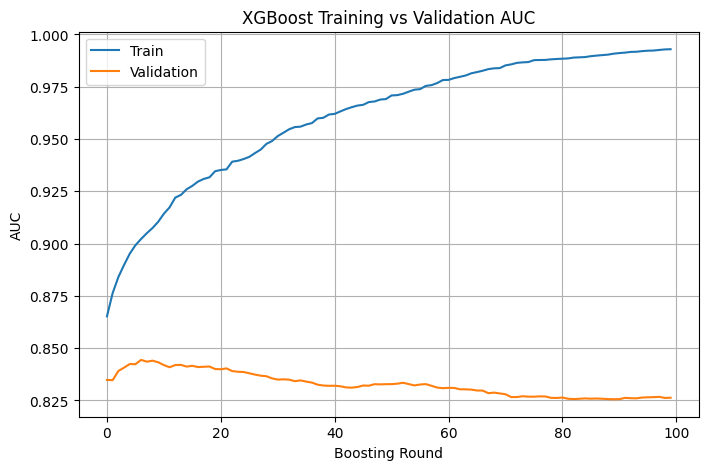

In [67]:
# try simple parameters

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

model, evals_result = train_xgb_model(xgb_params, dtrain, num_boost_round=100)
plot_evals_result(evals_result)


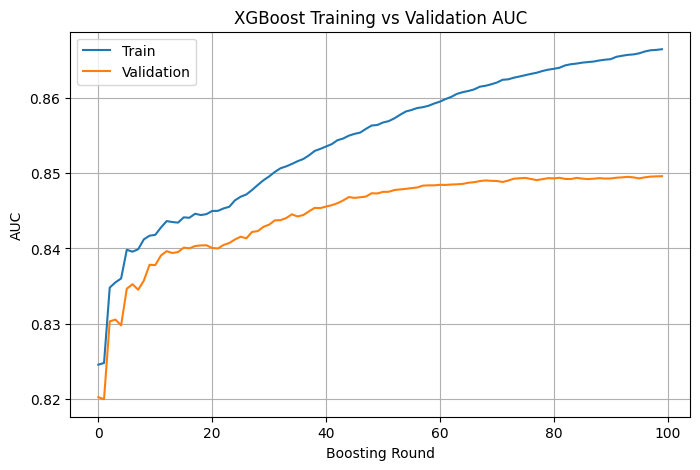

In [63]:
# It looks like the model is overfitting, try smaller parameters
# try simple parameters

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

model, evals_result = train_xgb_model(xgb_params, dtrain, num_boost_round=500)
plot_evals_result(evals_result)


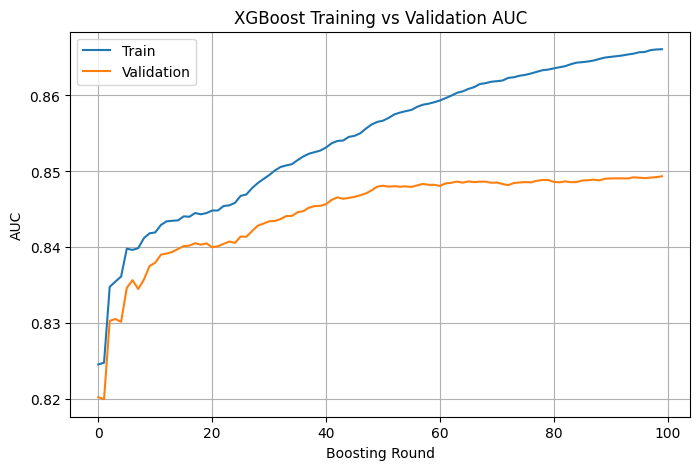

In [64]:
# add regularization parameters

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
    'lambda': 1,   # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'gamma': 0.2,  # Minimum loss to split
}

model, evals_result = train_xgb_model(xgb_params, dtrain, num_boost_round=500)
plot_evals_result(evals_result)


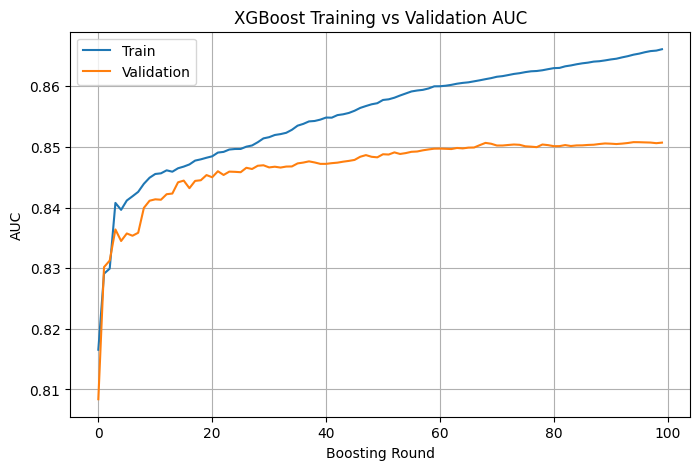

In [65]:
# add randomness parameter

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,

    'lambda': 1,   # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'gamma': 0.2,  # Minimum loss to split

    'subsample': 0.8,         # use 80% of data per tree
    'colsample_bytree': 0.8   # use 80% of features per tree
}

model, evals_result = train_xgb_model(xgb_params, dtrain, num_boost_round=500)
plot_evals_result(evals_result)


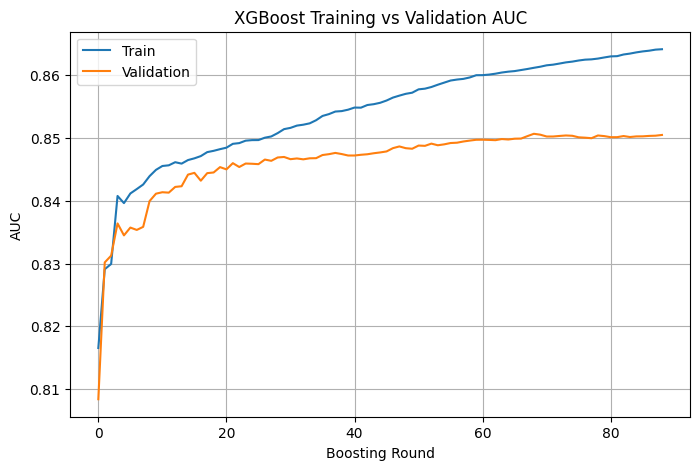

In [71]:
# add early stopping    

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,

    'lambda': 1,   # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'gamma': 0.2,  # Minimum loss to split

    'subsample': 0.8,         # use 80% of data per tree
    'colsample_bytree': 0.8   # use 80% of features per tree
}

model, evals_result = train_xgb_model(xgb_params, dtrain,
                                      num_boost_round=500,
                                      early_stopping_rounds=20)
plot_evals_result(evals_result)


# best iteration:
best_iter = model.best_iteration


cv_res = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    metrics='auc',
    early_stopping_rounds=20,
    seed=1,
    as_pandas=True
)



In [72]:
cv_res

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.818695,0.004286,0.807941,0.012497
1,0.828445,0.003188,0.819683,0.007738
2,0.834497,0.003621,0.827571,0.009918
3,0.839775,0.001747,0.832389,0.009959
4,0.840589,0.002702,0.833374,0.009375
...,...,...,...,...
79,0.865886,0.001830,0.845329,0.006828
80,0.866041,0.001832,0.845288,0.006816
81,0.866221,0.001848,0.845338,0.006815
82,0.866431,0.001850,0.845330,0.006739


In [75]:
best_iter

68

In [73]:
best_test_auc = cv_res['test-auc-mean'].max()

best_test_auc

0.8453712560663403

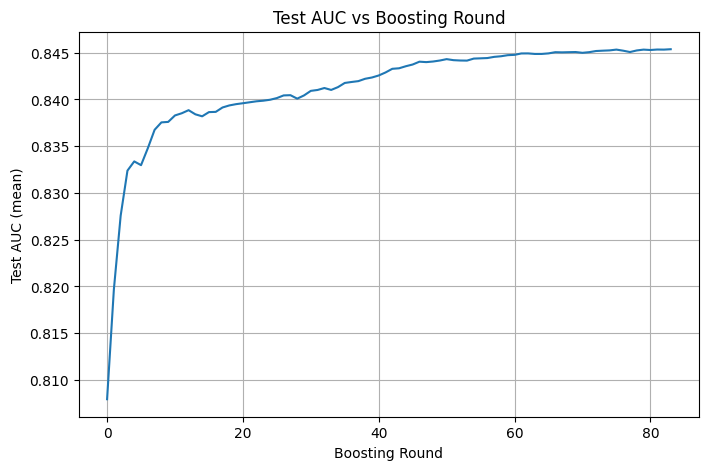

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(cv_res['test-auc-mean'])
plt.xlabel('Boosting Round')
plt.ylabel('Test AUC (mean)')
plt.title('Test AUC vs Boosting Round')
plt.grid(True)
plt.show()

## Find best threshold

In [91]:
best_model, best_evals_result = train_xgb_model(xgb_params, dtrain,
                                      num_boost_round=500,
                                      early_stopping_rounds=20)

y_val_best_pred = best_model.predict(dval)

thresholds = np.arange(0, 1.01, 0.01)

f1_scores = []
for t in thresholds:
    f1 = f1_score(y_val, y_val_best_pred > t)
    f1_scores.append(f1)
    #print(f'threshold={t:.2f} f1={f1:.4f}')
    
best_threshold = thresholds[np.argmax(f1_scores)]

print('Best threshold:', best_threshold)
print('Best f1 score:', max(f1_scores))

Best threshold: 0.25
Best f1 score: 0.6453546453546454


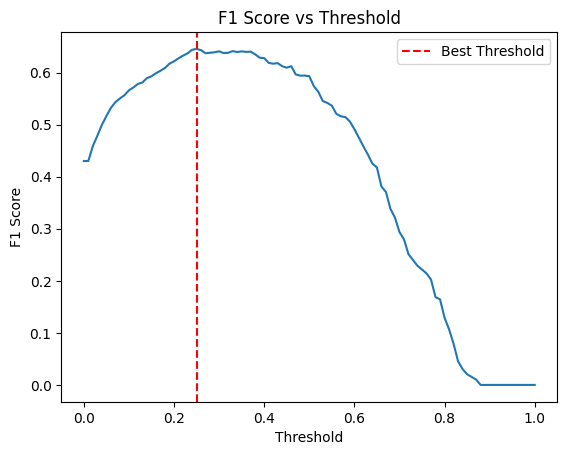

In [92]:
# plot f1 scores vs thresholds
plt.plot(thresholds, f1_scores)
# draw vertical line at best threshold
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

## Train final model

In [93]:
y_full_train = np.concatenate([y_train, y_val])

df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,

    'lambda': 1,   # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'gamma': 0.2,  # Minimum loss to split

    'subsample': 0.8,         # use 80% of data per tree
    'colsample_bytree': 0.8   # use 80% of features per tree
}

final_pipe = make_pipeline(
    DictVectorizer(sparse=False),
    xgb.XGBClassifier(**xgb_params, n_estimators=best_iter)
)

final_pipe.fit(X_full_train_dict, y_full_train)

# Predict on test
best_th = 0.25

X_test_dict = df_test.to_dict(orient='records')
y_test_pred = final_pipe.predict_proba(X_test_dict)[:, 1]
auc_test = roc_auc_score(y_test, y_test_pred)
f1 = f1_score(y_test, (y_test_pred >= best_th).astype(int))
print("auc test ",auc_test)
print("f1 test ",f1)







auc test  0.8564437149945292
f1 test  0.6150670794633643
